
https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor

from IPython.display import display

In [2]:
DATA_PATH = '../input'
SUBMISSIONS_PATH = './'
# use atomic numbers to recode atomic names
# 原子番号
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

In [4]:
data = pd.read_pickle('../input/data.covs.pickle')
data_train = data.loc[~data['scalar_coupling_constant'].isnull()].reset_index(drop=True)
data_test = data.loc[data['scalar_coupling_constant'].isnull()].reset_index(drop=True)
data_train=data_train.sort_values(by='id',ascending=True).reset_index()
data_train=data_train.drop(['index','molecule_name','atom_index_0','atom_index_1','type','scalar_coupling_constant'],axis=1)
data_test=data_test.sort_values(by='id',ascending=True).reset_index()
data_test=data_test.drop(['index','molecule_name','atom_index_0','atom_index_1','type','scalar_coupling_constant'],axis=1)

In [249]:
data_train.head()

,index,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,rc_A,rc_B,rc_C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv,freqs_min,freqs_max,freqs_mean,linear,mulliken_min,mulliken_max,mulliken_mean,mulliken_atom_0,mulliken_atom_1
0,1599908,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,157.7118,157.70997,157.70699,0.0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.47893,-40.476062,-40.475117,-40.498597,6.469,1341.307,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.0,0.133921,-0.535689
1,1599909,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,157.7118,157.70997,157.70699,0.0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.47893,-40.476062,-40.475117,-40.498597,6.469,1341.307,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.0,0.133921,0.133922
2,1599910,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,157.7118,157.70997,157.70699,0.0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.47893,-40.476062,-40.475117,-40.498597,6.469,1341.307,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.0,0.133921,0.133923
3,1599911,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,157.7118,157.70997,157.70699,0.0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.47893,-40.476062,-40.475117,-40.498597,6.469,1341.307,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.0,0.133921,0.133923
4,1599912,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,157.7118,157.70997,157.70699,0.0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.47893,-40.476062,-40.475117,-40.498597,6.469,1341.307,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.0,0.133922,-0.535689


In [250]:
train_csv.head()

,id,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,1,1,0,1JHC,84.807602
1,1,1,1,2,2JHH,-11.257000
2,2,1,1,3,2JHH,-11.254800
3,3,1,1,4,2JHH,-11.254300
4,4,1,2,0,1JHC,84.807404


In [5]:
data_train.head()

,id,rc_A,rc_B,rc_C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv,freqs_min,freqs_max,freqs_mean,linear,mulliken_min,mulliken_max,mulliken_mean,mulliken_atom_0,mulliken_atom_1
0,0,157.7118,157.70997,157.70699,0.0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.47893,-40.476062,-40.475117,-40.498597,6.469,1341.307,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.0,0.133921,-0.535689
1,1,157.7118,157.70997,157.70699,0.0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.47893,-40.476062,-40.475117,-40.498597,6.469,1341.307,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.0,0.133921,0.133922
2,2,157.7118,157.70997,157.70699,0.0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.47893,-40.476062,-40.475117,-40.498597,6.469,1341.307,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.0,0.133921,0.133923
3,3,157.7118,157.70997,157.70699,0.0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.47893,-40.476062,-40.475117,-40.498597,6.469,1341.307,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.0,0.133921,0.133923
4,4,157.7118,157.70997,157.70699,0.0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.47893,-40.476062,-40.475117,-40.498597,6.469,1341.307,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.0,0.133922,-0.535689


In [6]:
data_test.head()

,index,id,scalar_coupling_constant,rc_A,rc_B,rc_C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv,freqs_min,freqs_max,freqs_mean,linear,mulliken_min,mulliken_max,mulliken_mean,mulliken_atom_0,mulliken_atom_1
0,1664892,4658147,NaN,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,-0.207019
1,1664891,4658148,NaN,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,-0.207019
2,1664889,4658149,NaN,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,0.207019
3,1664890,4658150,NaN,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,-0.207019
4,1664888,4658151,NaN,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,-0.207019


In [5]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}/train.csv', index_col='id', dtype=train_dtypes)
# molecue nameをindex番号に変更
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


In [6]:
train_csv=train_csv.reset_index()
train_csv=pd.merge(train_csv,data_train,on='id',how='right')

In [7]:
submission_csv = pd.read_csv(f'{DATA_PATH}/sample_submission.csv', index_col='id')

In [8]:
test_csv = pd.read_csv(f'{DATA_PATH}/test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [9]:
test_csv=test_csv.reset_index()
test_csv=pd.merge(test_csv,data_test,on='id',how='right')

In [15]:
test_csv.head()

,id,molecule_index,atom_index_0,atom_index_1,type,rc_A,rc_B,rc_C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv,freqs_min,freqs_max,freqs_mean,linear,mulliken_min,mulliken_max,mulliken_mean,mulliken_atom_0,mulliken_atom_1
0,4658147,4,2,0,2JHC,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,-0.207019
1,4658148,4,2,1,1JHC,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,-0.207019
2,4658149,4,2,3,3JHH,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,0.207019
3,4658150,4,3,0,1JHC,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,-0.207019
4,4658151,4,3,1,2JHC,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,-0.207019


In [11]:
data_test.head()

,index,id,scalar_coupling_constant,rc_A,rc_B,rc_C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv,freqs_min,freqs_max,freqs_mean,linear,mulliken_min,mulliken_max,mulliken_mean,mulliken_atom_0,mulliken_atom_1
0,1664892,4658147,NaN,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,-0.207019
1,1664891,4658148,NaN,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,-0.207019
2,1664889,4658149,NaN,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,0.207019
3,1664890,4658150,NaN,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,-0.207019
4,1664888,4658151,NaN,0.0,35.610036,35.610036,0.0,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,549.7648,3557.8599,1683.122114,0.0,-0.207019,0.207019,0.0,0.207019,-0.207019


In [10]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}/structures.csv', dtype=structures_dtypes)
display(structures_csv.head())

# atom name=>index atom=>原子番号
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [11]:
def build_type_dataframes(base, structures, coupling_type):
    # type列を削除
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    # coupling_typeでのidを列で保存
    base['id'] = base['id'].astype('int32')
    # molecue_indexがtrainにあるものの特徴を取得
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures
#train_csv[train_csv['type']=='2JHC'].drop(['type'],axis=1).reset_index()
#structures_csv[structures_csv['molecule_index'].isin(train_csv['molecule_index'])]

In [12]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df
add_coordinates(train_csv,structures_csv,1)

,id,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant,rc_A,rc_B,rc_C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv,freqs_min,freqs_max,freqs_mean,linear,mulliken_min,mulliken_max,mulliken_mean,mulliken_atom_0,mulliken_atom_1,atom_1,x_1,y_1,z_1
0,0,1,1,0,1JHC,84.807602,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,1341.3070,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.000000e+00,0.133921,-0.535689,6,-0.012698,1.085804,0.008001
1,4,1,2,0,1JHC,84.807404,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,1341.3070,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.000000e+00,0.133922,-0.535689,6,-0.012698,1.085804,0.008001
2,7,1,3,0,1JHC,84.809303,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,1341.3070,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.000000e+00,0.133923,-0.535689,6,-0.012698,1.085804,0.008001
3,9,1,4,0,1JHC,84.809502,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,1341.3070,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.000000e+00,0.133923,-0.535689,6,-0.012698,1.085804,0.008001
4,1,1,1,2,2JHH,-11.257000,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,1341.3070,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.000000e+00,0.133921,0.133922,1,1.011731,1.463751,0.000277
5,2,1,1,3,2JHH,-11.254800,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,1341.3070,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.000000e+00,0.133921,0.133923,1,-0.540815,1.447527,-0.876644
6,5,1,2,3,2JHH,-11.254100,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,1341.3070,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.000000e+00,0.133922,0.133923,1,-0.540815,1.447527,-0.876644
7,3,1,1,4,2JHH,-11.254300,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,1341.3070,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.000000e+00,0.133921,0.133923,1,-0.523814,1.437933,0.906397
8,6,1,2,4,2JHH,-11.254800,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,1341.3070,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.000000e+00,0.133922,0.133923,1,-0.523814,1.437933,0.906397
9,8,1,3,4,2JHH,-11.254300,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,1341.3070,3151.7078,2182.525478,1.0,-0.535689,0.133923,0.000000e+00,0.133923,0.133923,1,-0.523814,1.437933,0.906397


In [13]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [14]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [15]:
# 2点の中心点
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

# 中心点からの距離
def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

# 原子間距離
def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [16]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [17]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [18]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
   
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
   
    
    full = add_atoms(base, atoms)
    
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    

    return full

In [20]:
# coupling_typeで原子数が異なるため、atom_9が最大となる

full=build_couple_dataframe(train_csv, structures_csv,'3JHC', n_atoms=10)

In [19]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = ['rc_A', 'rc_B', 'rc_C', 'mu', 'alpha',
       'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv',
       'freqs_min', 'freqs_max', 'freqs_mean', 'linear', 'mulliken_min',
       'mulliken_max', 'mulliken_mean', 'mulliken_atom_0', 'mulliken_atom_1']
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [21]:
# 1JHNは原子数が6までしかないのでいらない特徴量列を削減
df=take_n_atoms(full,10)
df=df.fillna(df.mean())

In [22]:
df.head()

,rc_A,rc_B,rc_C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv,freqs_min,freqs_max,freqs_mean,linear,mulliken_min,mulliken_max,mulliken_mean,mulliken_atom_0,mulliken_atom_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,scalar_coupling_constant
0,160.28041,8.59323,8.59321,0.7156,28.78,-0.2609,0.0613,0.3222,177.1963,0.055410,-116.609549,-116.605550,-116.604606,-116.633775,12.482,340.0245,3510.1131,1621.487893,1.0,-0.493017,0.286586,2.857143e-07,0.151087,-0.443025,6,6,1,1,1,0,0,0,3.218719,2.113945,1.201440,1.095263,2.656449,1.455009,1.768799,3.218524,2.113891,1.095256,1.768765,3.218673,2.113947,1.095266,4.238846,1.061451,2.262891,3.717900,2.942208,2.268227,2.162260,2.407879,3.155817,2.290419,2.304167,2.570511,3.304104,2.411283,2.452542,2.748722,4.55166
1,160.28041,8.59323,8.59321,0.7156,28.78,-0.2609,0.0613,0.3222,177.1963,0.055410,-116.609549,-116.605550,-116.604606,-116.633775,12.482,340.0245,3510.1131,1621.487893,1.0,-0.493017,0.286586,2.857143e-07,0.151092,-0.443025,6,6,1,1,1,0,0,0,3.218673,2.113947,1.201440,1.095266,2.656449,1.455009,1.768800,3.218524,2.113891,1.095256,1.768765,3.218719,2.113945,1.095263,4.238641,1.061451,2.262891,3.717900,2.942208,2.268227,2.162260,2.407879,3.155817,2.290419,2.304167,2.570511,3.304104,2.411283,2.452542,2.748722,4.55410
2,160.28041,8.59323,8.59321,0.7156,28.78,-0.2609,0.0613,0.3222,177.1963,0.055410,-116.609549,-116.605550,-116.604606,-116.633775,12.482,340.0245,3510.1131,1621.487893,1.0,-0.493017,0.286586,2.857143e-07,0.151097,-0.443025,6,6,1,1,1,0,0,0,3.218524,2.113891,1.201440,1.095256,2.656449,1.455009,1.768800,3.218673,2.113947,1.095266,1.768799,3.218719,2.113945,1.095263,4.238452,1.061451,2.262891,3.717900,2.942208,2.268227,2.162260,2.407879,3.155817,2.290419,2.304167,2.570511,3.304104,2.411283,2.452542,2.748722,4.55341
3,160.28041,8.59323,8.59321,0.7156,28.78,-0.2609,0.0613,0.3222,177.1963,0.055410,-116.609549,-116.605550,-116.604606,-116.633775,12.482,340.0245,3510.1131,1621.487893,1.0,-0.493017,0.286586,2.857143e-07,0.196182,-0.493017,6,6,1,1,1,0,0,0,3.717900,2.262891,1.455009,1.061451,2.656449,1.201440,4.238452,1.095256,2.113891,3.218524,4.238641,1.095266,2.113947,3.218673,4.238846,1.095263,2.113945,3.218719,2.942208,2.268227,2.162260,2.407879,3.155817,2.290419,2.304167,2.570511,3.304104,2.411283,2.452542,2.748722,2.51865
4,29.45018,8.37701,7.42076,0.0597,34.75,-0.3230,0.0949,0.4179,227.1361,0.103182,-119.052475,-119.047927,-119.046983,-119.078157,14.840,218.9418,3100.8500,1677.470830,1.0,-0.357354,0.112011,-9.090909e-08,0.112011,-0.357354,6,6,1,1,1,1,1,1,2.818033,2.180575,1.531257,1.095946,2.552022,1.531257,2.640858,1.095948,2.180575,2.817791,2.526504,2.160276,1.097266,2.160276,1.766637,2.817789,2.180575,1.095948,3.177659,1.095946,2.180575,2.818031,3.078933,2.160276,1.097266,2.160277,1.768910,3.506680,2.185673,1.094660,2.51277


In [47]:
full.columns[:30]

Index(['index', 'id', 'molecule_index', 'atom_index_0', 'atom_index_1',
       'scalar_coupling_constant', 'rc_A', 'rc_B', 'rc_C', 'mu', 'alpha',
       'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv',
       'freqs_min', 'freqs_max', 'freqs_mean', 'linear', 'mulliken_min',
       'mulliken_max', 'mulliken_mean', 'mulliken_atom_0', 'mulliken_atom_1'],
      dtype='object')

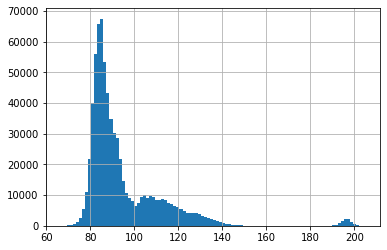

In [197]:
df['scalar_coupling_constant'].hist(bins=100)

In [117]:
bins=np.linspace(df['scalar_coupling_constant'].min(),df['scalar_coupling_constant'].max(),500)
df['bins_scalar_coupling']=np.digitize(df['scalar_coupling_constant'],bins=bins)

C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [128]:
bins_mean=df.groupby('bins_scalar_coupling').aggregate('mean').reset_index().drop(['atom_2', 'atom_3', 'atom_4', 'atom_5','atom_6','scalar_coupling_constant'],axis=1)

In [138]:
df['index']=df.index
merge_df=pd.merge(df,bins_mean,on='bins_scalar_coupling',how='right').sort_values(by='index').reset_index().drop(['level_0','index'],axis=1)
fill_cols=['d_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3']
for col in fill_cols:
    merge_df[col+'_x']=merge_df[col+'_x'].fillna(merge_df[col+'_y'])

C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [141]:
merge_df=merge_df.drop(['d_1_0_y', 'd_2_0_y', 'd_2_1_y', 'd_3_0_y',
       'd_3_1_y', 'd_3_2_y', 'd_4_0_y', 'd_4_1_y', 'd_4_2_y', 'd_4_3_y',
       'd_5_0_y', 'd_5_1_y', 'd_5_2_y', 'd_5_3_y', 'd_6_0_y', 'd_6_1_y',
       'd_6_2_y', 'd_6_3_y'],axis=1)

In [223]:
fill_cols=['d_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3']
df['d_mean']=sum(df[col] for col in fill_cols)/len(fill_cols)

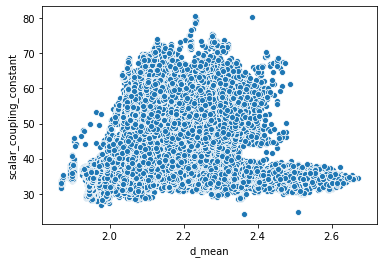

In [225]:
sns.scatterplot(x='d_mean',y='scalar_coupling_constant',data=df)

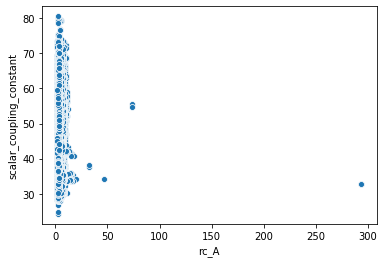

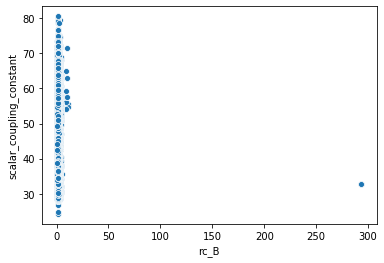

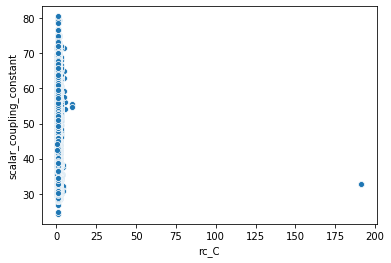

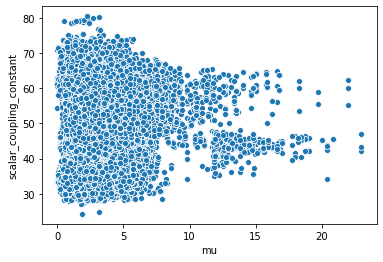

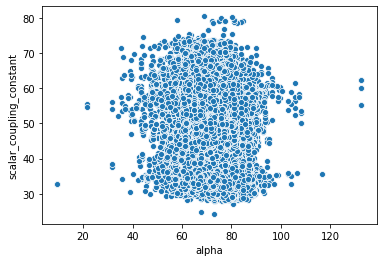

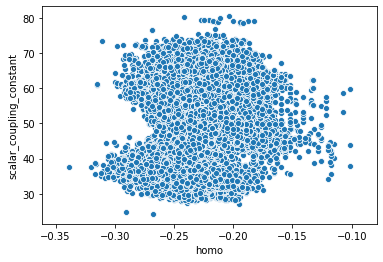

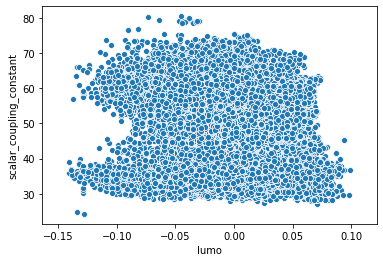

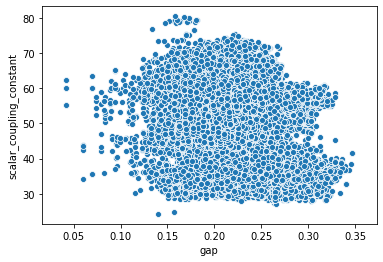

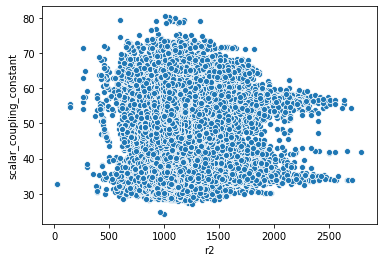

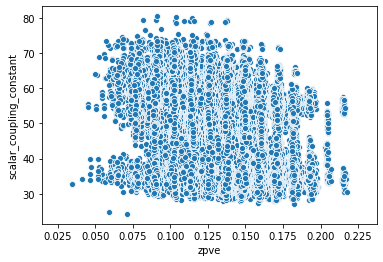

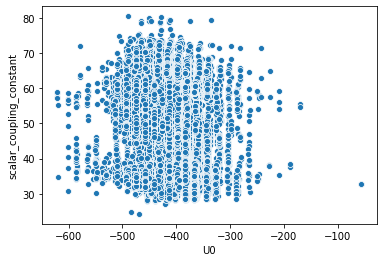

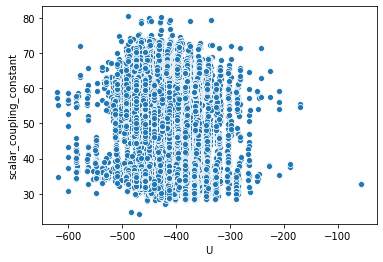

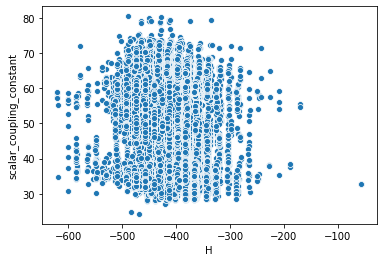

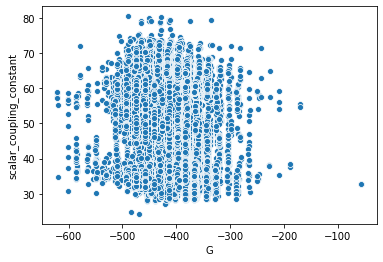

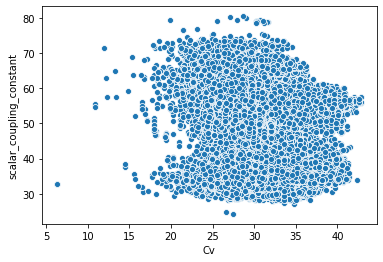

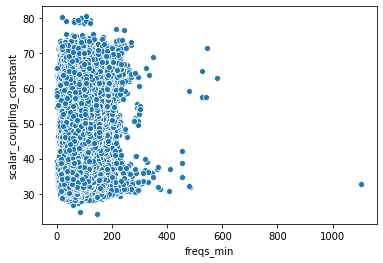

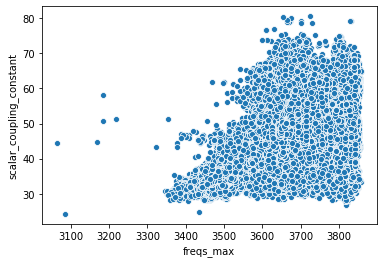

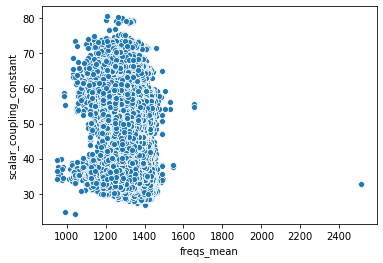

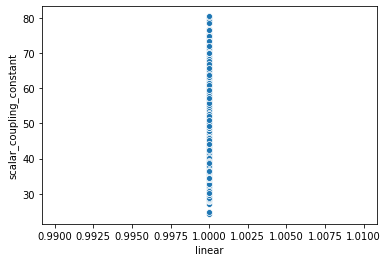

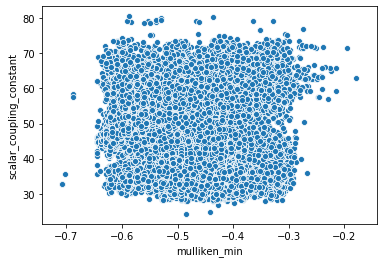

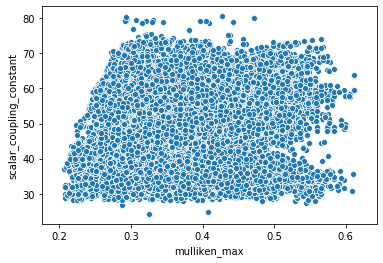

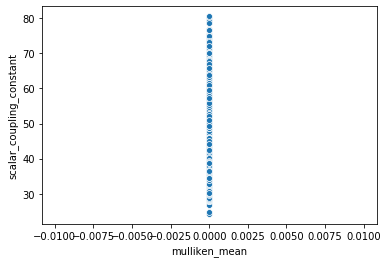

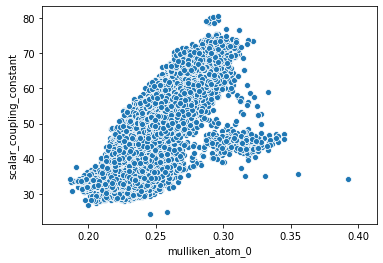

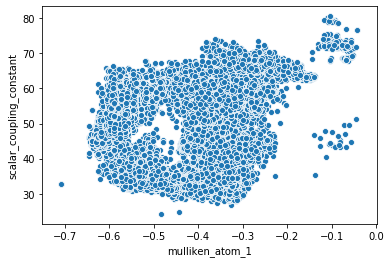

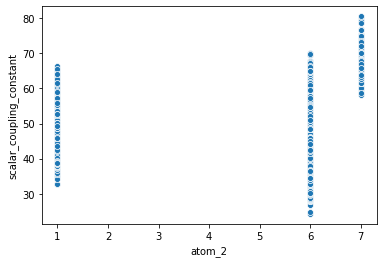

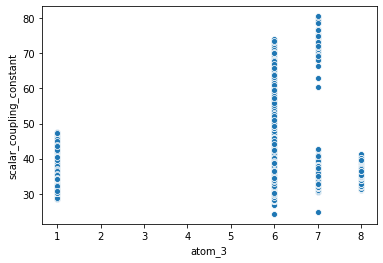

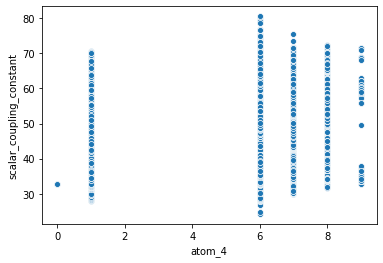

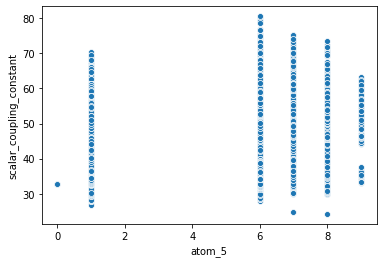

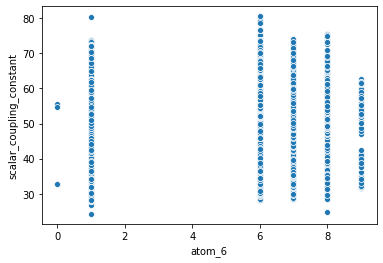

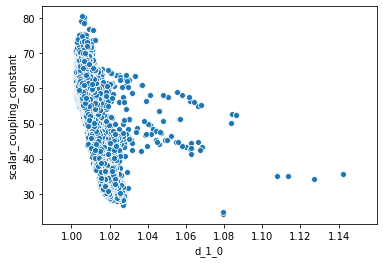

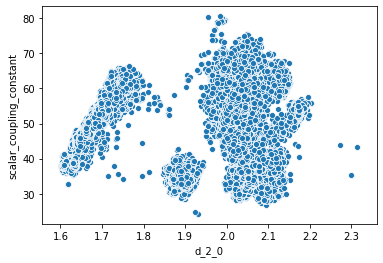

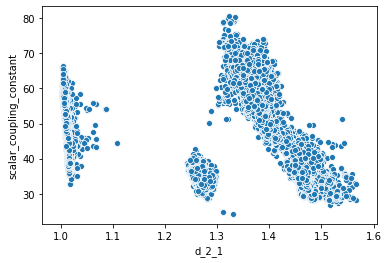

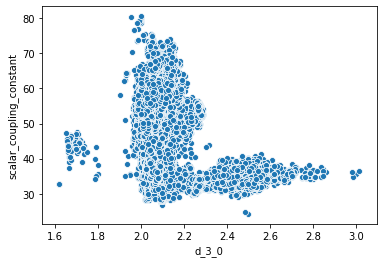

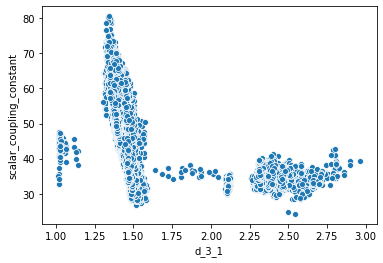

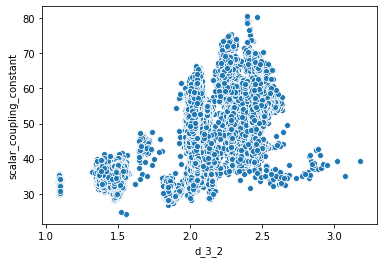

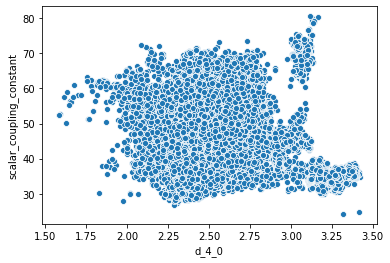

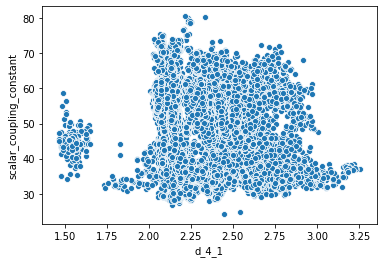

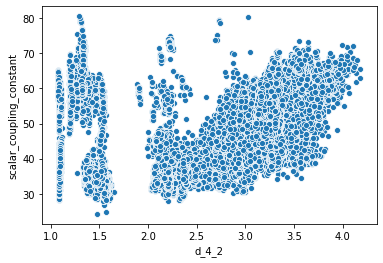

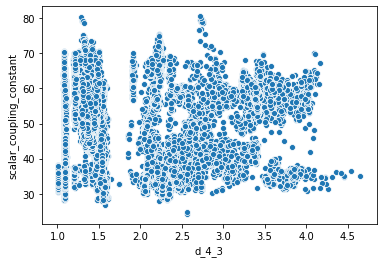

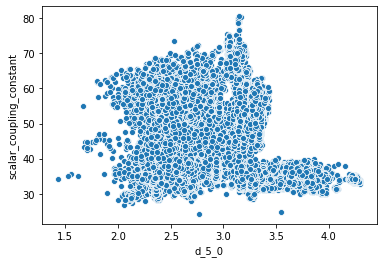

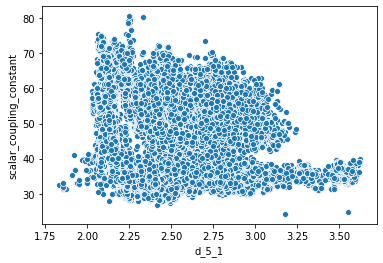

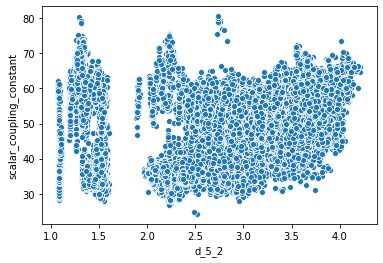

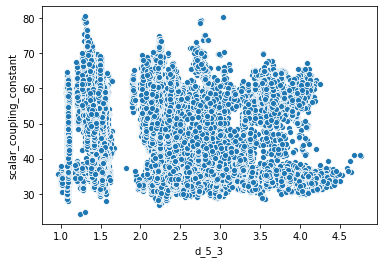

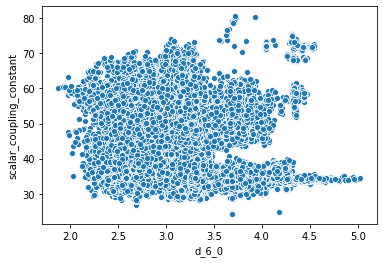

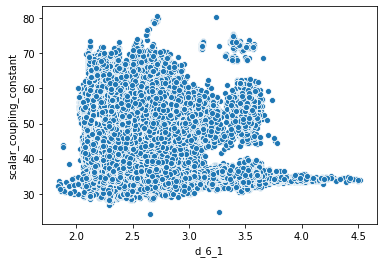

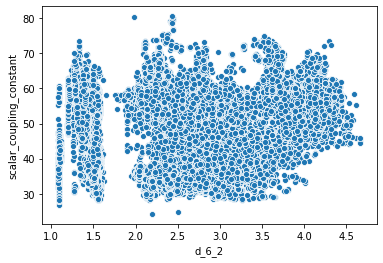

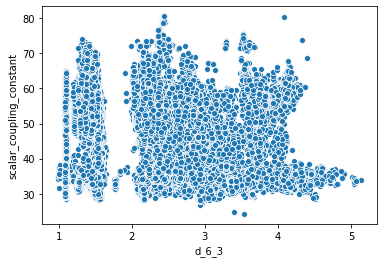

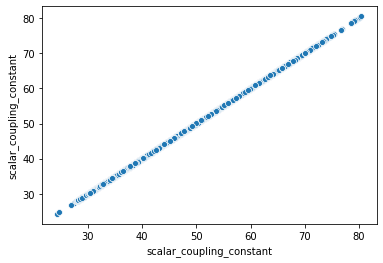

In [56]:
data=df.fillna(0)
for col in data.columns:
    sns.scatterplot(x=col,y='scalar_coupling_constant',data=data)
    plt.show()

In [191]:
train_csv['type'].value_counts()

3JHC    1510379
2JHC    1140674
1JHC    709416 
3JHH    590611 
2JHH    378036 
3JHN    166415 
2JHN    119253 
1JHN    43363  
Name: type, dtype: int64

In [57]:
X_data=df.drop(['scalar_coupling_constant'],axis=1)
y_data=df.scalar_coupling_constant
X_train,X_val,y_train,y_val=train_test_split(X_data,y_data,test_size=0.2,random_state=0)


In [29]:
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 128,
    'min_child_samples': 79,
    'max_depth': 9,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [207]:
import optuna
def opt(trial):
    n_estimators = trial.suggest_int('n_estimators', 0, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    model_opt = LGBMRegressor(
        random_state=42,
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
    )
    model_opt.fit(X_train,y_train)
    y_pred = model_opt.predict(X_val)
    return mean_absolute_error(y_val,y_pred)

model_opt=LGBMRegressor()
study = optuna.create_study()
study.optimize(opt, n_trials=100)

[I 2019-08-25 14:43:35,076] Finished trial#0 resulted in value: 0.6374519492722115. Current best value is 0.6374519492722115 with parameters: {'n_estimators': 98, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[I 2019-08-25 14:43:38,037] Finished trial#1 resulted in value: 0.45142910119604807. Current best value is 0.45142910119604807 with parameters: {'n_estimators': 610, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.9, 'colsample_bytree': 0.7}.
[I 2019-08-25 14:43:41,907] Finished trial#2 resulted in value: 0.4233734445940574. Current best value is 0.4233734445940574 with parameters: {'n_estimators': 793, 'max_depth': 10, 'min_child_weight': 19, 'subsample': 0.6, 'colsample_bytree': 0.8}.
[I 2019-08-25 14:43:45,044] Finished trial#3 resulted in value: 0.47411934955187346. Current best value is 0.4233734445940574 with parameters: {'n_estimators': 793, 'max_depth': 10, 'min_child_weight': 19, 'subsample': 0.6, 'colsample_bytree': 0.8}.
[I 20

[I 2019-08-25 14:48:05,646] Finished trial#64 resulted in value: 0.4661658777406905. Current best value is 0.40724768994516714 with parameters: {'n_estimators': 954, 'max_depth': 19, 'min_child_weight': 15, 'subsample': 0.5, 'colsample_bytree': 0.7}.
[I 2019-08-25 14:48:15,162] Finished trial#65 resulted in value: 0.415287492758894. Current best value is 0.40724768994516714 with parameters: {'n_estimators': 954, 'max_depth': 19, 'min_child_weight': 15, 'subsample': 0.5, 'colsample_bytree': 0.7}.
[I 2019-08-25 14:48:24,309] Finished trial#66 resulted in value: 0.42617824756184014. Current best value is 0.40724768994516714 with parameters: {'n_estimators': 954, 'max_depth': 19, 'min_child_weight': 15, 'subsample': 0.5, 'colsample_bytree': 0.7}.
[I 2019-08-25 14:48:33,730] Finished trial#67 resulted in value: 0.4229417155849247. Current best value is 0.40724768994516714 with parameters: {'n_estimators': 954, 'max_depth': 19, 'min_child_weight': 15, 'subsample': 0.5, 'colsample_bytree': 0.

In [208]:
print(study.best_params)
print(1-study.best_value)

{'n_estimators': 954, 'max_depth': 19, 'min_child_weight': 15, 'subsample': 0.5, 'colsample_bytree': 0.7}
0.5927523100548329


In [60]:
model=LGBMRegressor(**LGB_PARAMS,n_jobs=-1)
model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='mae',verbose=100,early_stopping_rounds=200)
y_pred=model.predict(X_val)
print(np.log(mean_absolute_error(y_val,y_pred)))

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.345492	valid_1's l1: 0.450975
Did not meet early stopping. Best iteration is:
[100]	training's l1: 0.345492	valid_1's l1: 0.450975
-0.7963434592643981


In [ ]:
cols=list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance=pd.DataFrame({'features':cols,'importance':model.feature_importances_})
sns.barplot(x='importance',y='features',data=df_importance.sort_values(by='importance',ascending=False))
print(cols)

In [24]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    '''
    # 欠損値を平均値で埋める
    display(df.head())
    bins=np.linspace(df['scalar_coupling_constant'].min(),df['scalar_coupling_constant'].max(),500)
    df['bins_scalar_coupling']=np.digitize(df['scalar_coupling_constant'],bins=bins)
    
    bins_mean=df.groupby('bins_scalar_coupling').aggregate('mean').reset_index()
    drop_cols=['atom_'+str(x) for x in range(2,n_atoms)]
    drop_cols.append('scalar_coupling_constant')
    print(drop_cols)
    bins_mean=bins_mean.drop(drop_cols,axis=1)
    display(bins_mean.head())
    
    
    df['index']=df.index
    merge_df=pd.merge(df,bins_mean,on='bins_scalar_coupling',how='right').sort_values(by='index').reset_index().drop(['level_0','index'],axis=1)
    display(merge_df.head())
    #for col in fill_cols:
    #merge_df[col+'_x']=merge_df[col+'_x'].fillna(merge_df[col+'_y'])
    '''
    
    df = df.fillna(0)
    #display(df)
    print(df.columns)
    
# train data
# numpy配列として返す
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
# test data
    else:
        X_data = df.values.astype('float32')
        y_data = None
    
    return X_data, y_data

In [25]:
build_x_y_data(train_csv,'3JHC',10)

Index(['rc_A', 'rc_B', 'rc_C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2',
       'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'freqs_min', 'freqs_max',
       'freqs_mean', 'linear', 'mulliken_min', 'mulliken_max', 'mulliken_mean',
       'mulliken_atom_0', 'mulliken_atom_1', 'atom_2', 'atom_3', 'atom_4',
       'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2', 'd_8_3',
       'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3', 'scalar_coupling_constant'],
      dtype='object')


(array([[160.28041  ,   8.59323  ,   8.59321  , ...,   0.       ,
           0.       ,   0.       ],
        [160.28041  ,   8.59323  ,   8.59321  , ...,   0.       ,
           0.       ,   0.       ],
        [160.28041  ,   8.59323  ,   8.59321  , ...,   0.       ,
           0.       ,   0.       ],
        ...,
        [  3.52845  ,   2.15131  ,   1.86582  , ...,   3.0729578,
           2.2663789,   3.3587475],
        [  3.52845  ,   2.15131  ,   1.86582  , ...,   2.5030496,
           2.3111644,   2.4236994],
        [  3.52845  ,   2.15131  ,   1.86582  , ...,   1.952973 ,
           2.5798912,   1.5606465]], dtype=float32),
 array([4.55166 , 4.5541  , 4.55341 , ..., 1.94438 , 0.568997, 1.17337 ],
       dtype=float32))

In [27]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    print(f'*** Training Model for {coupling_type} ***')
    
# coupling_typeごとに特徴量を生成する(train)
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
# coupling_typeごとに特徴量を生成する(test)
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
# testの予測値を格納
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
    # submissionの予測したcoupling}_typeでの値を変更
    tmp=test_csv.copy()
    tmp=tmp.set_index('id')
    submission.loc[tmp['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

In [30]:
# coupling_type別に使われている原子数が異なるため、その値を格納
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}
N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHN ***
Index(['rc_A', 'rc_B', 'rc_C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2',
       'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'freqs_min', 'freqs_max',
       'freqs_mean', 'linear', 'mulliken_min', 'mulliken_max', 'mulliken_mean',
       'mulliken_atom_0', 'mulliken_atom_1', 'atom_2', 'atom_3', 'atom_4',
       'atom_5', 'atom_6', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1',
       'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2',
       'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['rc_A', 'rc_B', 'rc_C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2',
       'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'freqs_min', 'freqs_max',
       'freqs_mean', 'linear', 'mulliken_min', 'mulliken_max', 'mulliken_mean',
       'mulliken_atom_0', 'mulliken_atom_1', 'atom_2', 'atom_3', 'atom_4',
       'atom_5', 'atom_6', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1',
       'd_3_2', 'd_4_0', 'd_4_1', 'd_4_

[1200]	training's l1: 0.478368	valid_1's l1: 0.756685
[1300]	training's l1: 0.45879	valid_1's l1: 0.749771
[1400]	training's l1: 0.440472	valid_1's l1: 0.743946
[1500]	training's l1: 0.42351	valid_1's l1: 0.738627
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.42351	valid_1's l1: 0.738627
1JHC Fold 2, logMAE: -0.30296275020227975
*** Training Model for 2JHH ***
Index(['rc_A', 'rc_B', 'rc_C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2',
       'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'freqs_min', 'freqs_max',
       'freqs_mean', 'linear', 'mulliken_min', 'mulliken_max', 'mulliken_mean',
       'mulliken_atom_0', 'mulliken_atom_1', 'atom_2', 'atom_3', 'atom_4',
       'atom_5', 'atom_6', 'atom_7', 'atom_8', 'd_1_0', 'd_2_0', 'd_2_1',
       'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0',
       'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0',
       'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2', 'd_8_3',
       'sca

[300]	training's l1: 0.121982	valid_1's l1: 0.187666
[400]	training's l1: 0.104683	valid_1's l1: 0.181384
[500]	training's l1: 0.0910381	valid_1's l1: 0.177305
[600]	training's l1: 0.0796187	valid_1's l1: 0.174538
[700]	training's l1: 0.0697177	valid_1's l1: 0.172369
[800]	training's l1: 0.0621494	valid_1's l1: 0.17069
[900]	training's l1: 0.0553835	valid_1's l1: 0.169378
[1000]	training's l1: 0.0494993	valid_1's l1: 0.168326
[1100]	training's l1: 0.0443353	valid_1's l1: 0.167435
[1200]	training's l1: 0.0398617	valid_1's l1: 0.166689
[1300]	training's l1: 0.0359391	valid_1's l1: 0.166026
[1400]	training's l1: 0.0323264	valid_1's l1: 0.165509
[1500]	training's l1: 0.0291967	valid_1's l1: 0.165037
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0291967	valid_1's l1: 0.165037
2JHN Fold 2, logMAE: -1.8015878893104325
*** Training Model for 2JHC ***
Index(['rc_A', 'rc_B', 'rc_C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2',
       'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'f

[1400]	training's l1: 0.108554	valid_1's l1: 0.193861
[1500]	training's l1: 0.10418	valid_1's l1: 0.192603
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.10418	valid_1's l1: 0.192603
3JHH Fold 1, logMAE: -1.64712201747244
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.287298	valid_1's l1: 0.303022
[200]	training's l1: 0.236338	valid_1's l1: 0.261584
[300]	training's l1: 0.208968	valid_1's l1: 0.24204
[400]	training's l1: 0.190144	valid_1's l1: 0.230017
[500]	training's l1: 0.175876	valid_1's l1: 0.221925
[600]	training's l1: 0.163939	valid_1's l1: 0.215372
[700]	training's l1: 0.153958	valid_1's l1: 0.210603
[800]	training's l1: 0.145513	valid_1's l1: 0.207039
[900]	training's l1: 0.137626	valid_1's l1: 0.203681
[1000]	training's l1: 0.130787	valid_1's l1: 0.201028
[1100]	training's l1: 0.124455	valid_1's l1: 0.19874
[1200]	training's l1: 0.118851	valid_1's l1: 0.196844
[1300]	training's l1: 0.113635	valid_1's l1: 0.195113

[200]	training's l1: 0.117095	valid_1's l1: 0.154298
[300]	training's l1: 0.0993932	valid_1's l1: 0.146447
[400]	training's l1: 0.0854131	valid_1's l1: 0.140865
[500]	training's l1: 0.0748512	valid_1's l1: 0.137159
[600]	training's l1: 0.0662372	valid_1's l1: 0.134495
[700]	training's l1: 0.0592972	valid_1's l1: 0.132537
[800]	training's l1: 0.0530776	valid_1's l1: 0.131002
[900]	training's l1: 0.0477813	valid_1's l1: 0.12995
[1000]	training's l1: 0.0431792	valid_1's l1: 0.12897
[1100]	training's l1: 0.0391222	valid_1's l1: 0.128135
[1200]	training's l1: 0.0355213	valid_1's l1: 0.127552
[1300]	training's l1: 0.0322722	valid_1's l1: 0.12701
[1400]	training's l1: 0.0294262	valid_1's l1: 0.126537
[1500]	training's l1: 0.0269	valid_1's l1: 0.126144
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0269	valid_1's l1: 0.126144
3JHN Fold 1, logMAE: -2.070330855603734
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.148372	valid_1's l1

In [31]:
submission.to_csv('lightgbm_qm9_dist.csv')